In [1]:
import numpy as np
import minterpy as mp
from minterpy.extras.regression import *
from matplotlib import pyplot as plt

import torch
import torchvision
from torchvision import transforms, datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.neighbors import NearestNeighbors

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from matplotlib.colors import Normalize

import nibabel as nib

In [2]:
image_path = '/media/chethan/New Volume/Thesis/mri_learning/mri_dwi_dataset/OASIS3/OAS30063/OAS30063_MR_d0160/dwi1/NIFTI/sub-OAS30063_ses-d0160_dwi.nii.gz'

image_obj = nib.load(image_path)

print(f'Type of the image{type(image_obj)}.')
image_data = image_obj.get_fdata()
type(image_data)

image_data[np.where(image_data < 0)] = 0
image_data = (image_data - image_data.min()) / ((image_data.max() - image_data.min()))
#print(image_data.mean())
#image_data[np.where(image_data < image_data.mean()+image_data.std())] = 0
#image_data = image_data / image_data.max()

cleaned_image = image_data[:,:,40,0]
cleaned_image.shape

Type of the image<class 'nibabel.nifti1.Nifti1Image'>.


(96, 96)

In [3]:
orig = cleaned_image
im_len = orig.shape[0]
im_len

96

In [4]:
import numpy as np
import torch
#import sys
import jmp_solver
#sys.path.insert(1, '/home/suarez08/PhD_PINNs/PIPS_framework')
from jmp_solver import *
from jmp_solver.sobolev import Sobolev
from jmp_solver.sobolev import Sobolev
from jmp_solver.solver import Solver
from jmp_solver.utils import matmul
import jmp_solver.surrogates
import time
#sys.path.insert(1, '/home/suarez08/minterpy/src')
import minterpy as mp
from jmp_solver.diffeomorphisms import hyper_rect
import matplotlib
import matplotlib.pyplot as plt
#style.use('dark_background')
matplotlib.rcdefaults() 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [5]:
#try out bilinear interpolation to get legendre image

def getLejaOrderedImage(im2d, Q_exact):
    Q_exact_sorted = (Q_exact)
    leg_pts_image_sorted = torch.tensor([])
    for i in Q_exact_sorted:
        for j in Q_exact_sorted:
            i_int = i.astype(int)
            j_int = j.astype(int)
            if(i_int == 0 or i_int == (im_len-1) or j_int == 0 or j_int == (im_len-1) ):
                req_value = im2d[i_int][j_int]
            else:
                x_co_1 = i_int
                x_co_2 = i_int+1
                y_co_1 =j_int
                y_co_2 = j_int+1

                Q_ev_11 = im2d[x_co_1][y_co_1]
                Q_ev_12 = im2d[x_co_1][y_co_2]
                Q_ev_21 = im2d[x_co_2][y_co_1]
                Q_ev_22 = im2d[x_co_2][y_co_2]

                x_co = i
                y_co = j

                term_1 = ( ( ( (x_co_2 - x_co) * (y_co_2 - y_co) ) / ( (x_co_2 - x_co_1) * (y_co_2 - y_co_1) ) ) * Q_ev_11)
                term_2 = (( ( (x_co - x_co_1) * (y_co_2 - y_co) ) / ( (x_co_2 - x_co_1) * (y_co_2 - y_co_1) ) ) * Q_ev_21)
                term_3 = ( ( ( (x_co_2 - x_co) * (y_co - y_co_1) ) / ( (x_co_2 - x_co_1) * (y_co_2 - y_co_1) ) ) * Q_ev_12)
                term_4 = ( ( ( (x_co - x_co_1) * (y_co - y_co_1) ) / ( (x_co_2 - x_co_1) * (y_co_2 - y_co_1) ) ) * Q_ev_22)

                req_value = term_1 + term_2 + term_3 + term_4                
            Fr1 = torch.tensor([req_value])
            leg_pts_image_sorted = torch.cat((leg_pts_image_sorted, Fr1)) 
    return leg_pts_image_sorted





In [6]:
deg_quad = 40
rect = rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])
print(rect.shape)
diffeo_param = hyper_rect(*rect)
print('diffeo_param',diffeo_param)
sob_param = Sobolev(deg=deg_quad, dim=2)
print('sob_param',sob_param)

##### Sobolev norm for the inteprolation
sob_param.set_s(0)
#####
x_plt, _, _, x, _, _ = sob_param.get_quad()
metric_param = sob_param.metric()
W_param = sob_param.get_leja_weights()
u_ob = jmp_solver.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
metric_2d = sob_param.metric(weak=True)
x_l = sob_param.get_xs()
X_p = u_ob.data_axes([x,x]).T

(2, 2)
diffeo_param (<function hyper_rect.<locals>.<lambda> at 0x7efe41d004c0>, <function hyper_rect.<locals>.<lambda> at 0x7efe41cb4a60>)
sob_param <jmp_solver.sobolev.Sobolev object at 0x7efe41cc4250>


In [7]:
Q_exact = im_len/2 *(x+1)
#Q = Q_exact.astype(int)

In [8]:
imageBilinearEncoded = getLejaOrderedImage(orig, Q_exact)


In [9]:
# Solve the analytic gradient flow, the trained model is u_ob

def getImageFromCoefficients(imageBilinearEncoded,X_p ):
    Fr = imageBilinearEncoded
    Fr = torch.tensor(Fr)
    start = time.time()
    K = torch.eye(len(X_p))
    KsK = matmul(X_p.T, metric_2d(matmul(torch.diag(W_param),X_p)))
    Ksf = matmul(X_p.T, metric_2d(matmul(torch.diag(W_param),Fr)))
    w = matmul(KsK.inverse(), Ksf)
    u_ob.set_weights(w)
    end = time.time()
    #print('time consumption: %.2fs' % (end-start))

    Ksf = matmul(X_p.T, metric_2d(matmul(torch.diag(W_param),Fr)))
    w = matmul(KsK.inverse(), Ksf)
    u_ob.set_weights(w)


    b = np.linspace(-1,1,im_len)#np.array([x[0]])#np.linspace(-1,1,100)
    xf= np.linspace(-1,1,im_len)#x#np.linspace(-1,1,100)
    BF, XF = np.meshgrid(b,xf)

    X_test = u_ob.data_axes([b,xf]).T
    #print('X_test.shape',X_test.shape)
    X_final = u_ob.data_axes([x,x]).T
    pred = u_ob(X_test).T[0].reshape(len(b),len(xf)).detach().numpy()
    GT = Fr.reshape(len(x),len(x))
    pred[np.where(pred < 0.0)] = 0
    recIM = pred.reshape(im_len,im_len)

    return recIM

In [10]:
recIM = getImageFromCoefficients(imageBilinearEncoded,X_p )

/tmp/ipykernel_10219/1353063009.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Fr = torch.tensor(Fr)


In [11]:

imageBilinearEncoded.shape

torch.Size([1681])

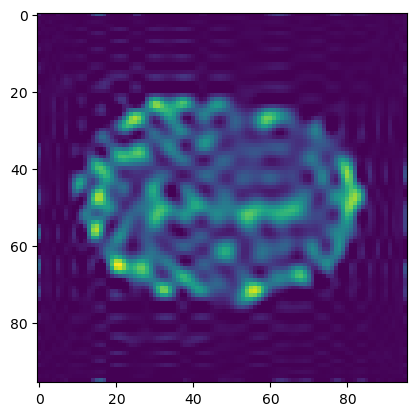

In [12]:

plt.imshow(recIM)


In [13]:
testRK = getLejaOrderedImage(orig, Q_exact)
#testRK = testRK.float()
#recIM = torch.matmul(X_p.float(), testRK.T).T
#recIM = recIM.reshape(32,32)

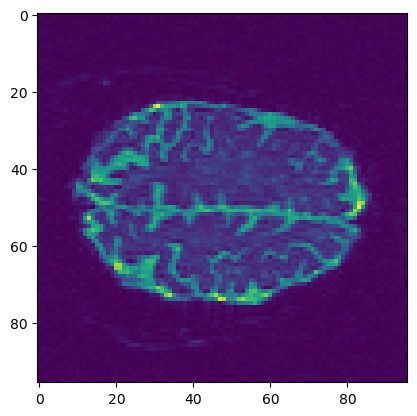

In [14]:
plt.imshow(orig)

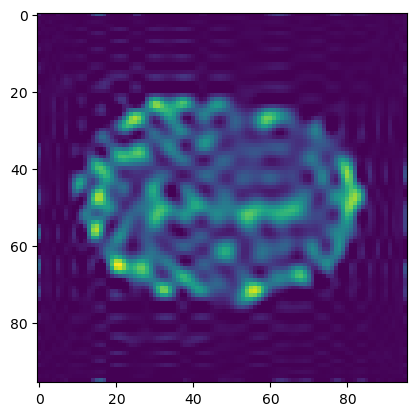

In [15]:
plt.imshow(recIM)

In [16]:
# PSNR of direct backward reconstruction of coefficients without perturbation 
orig_normal = Normalize()(orig)
recIM_norm = Normalize()(recIM)
psnr(orig_normal, recIM_norm, data_range=1.)

19.346862548625474

In [17]:
# MSE of direct reconstruction

np.mean(((orig_normal - np.array(recIM_norm))**2)*0.5)

0.005811439881817166

In [18]:
prozs = [0.2, 0.2, 0.5, 0.7] 

In [19]:
orig = np.array(orig)

In [20]:
rand_perturb = []

testRK_pert = np.array(testRK)
testRK_pert = testRK_pert.reshape(1,testRK_pert.shape[0])
for proz in prozs:
    
    rand_perturb.append(np.random.rand(1,testRK_pert.shape[1])*(np.max(testRK_pert)-np.min(testRK_pert))*proz)

In [21]:
rand_perturb[0].shape

(1, 1681)

In [22]:
orig_perturb = []
for rand_transform in rand_perturb:
    orig_perturb.append(torch.from_numpy(np.add(testRK_pert,rand_transform)).reshape(rand_transform.shape))#.to(device))
    #rec_perturb.append(model(orig_perturb[-1].float()))

In [23]:
# reconstruction from 10% perturbed
#testRK = get_all_thetas(orig)
#testRK = testRK.float()
pert_coeff = torch.tensor(orig_perturb[0]).float()
recIM_pert10 = getImageFromCoefficients(pert_coeff[0].double(),X_p)
recIM_pert10 = recIM_pert10.reshape(im_len,im_len)

/tmp/ipykernel_10219/1176423174.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pert_coeff = torch.tensor(orig_perturb[0]).float()
/tmp/ipykernel_10219/1353063009.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Fr = torch.tensor(Fr)


In [24]:
testRK_pert.shape

(1, 1681)

In [25]:
#MSE of coefficient perturbnbation
np.mean(((testRK_pert - np.array(pert_coeff))**2)*0.5)

0.0012371954147491866

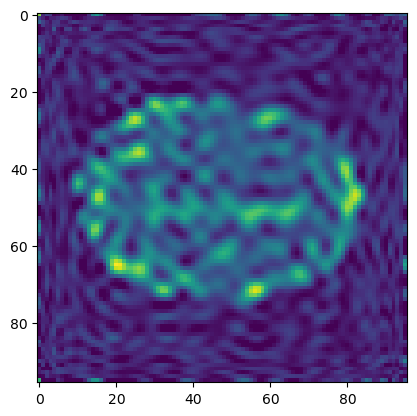

In [26]:
plt.imshow(recIM_pert10)

In [27]:
orig_normal.shape

(96, 96)

In [28]:
# PSNR of direct backward reconstruction of coefficients without perturbation 
orig_normal = Normalize()(orig)
recIM_pert10_norm = Normalize()(recIM_pert10)
psnr(orig_normal, recIM_pert10_norm, data_range=1.)

16.472903604930618

In [29]:
#what is MSE of initial and final images

np.mean(((orig_normal - recIM_pert10_norm)**2)*0.5)

0.011263662885942114